In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nengo
from nengolib.stats import ball

import nengo_spa as spa
from ssp.maps import Spatial2D

In [3]:
# Adaoted from ssp_grid_cell_utils.py and ssp_grid_cell_examples.ipynb
# Accurate representation for spatial cognition using grid cells
# Nicole Sandra-Yaffa Dumont & Chris Eliasmith

def ssp_plane_basis(K):
    # Create the bases vectors X,Y as described in the paper with the wavevectors 
    # (k_i = (u_i,v_i)) given in a matrix K. To get hexganal patterns use 3 K vectors 120 degs apart
    # To get mulit-scales/orientation, give many such sets of 3 K vectors 
    # K is _ by 2 
    d = K.shape[0]
    FX = np.ones((d*2 + 1,), dtype="complex")
    FX[0:d] = np.exp(1.j*K[:,0])
    FX[-d:] = np.flip(np.conj(FX[0:d]))
    FX = np.fft.ifftshift(FX)
    FY = np.ones((d*2 + 1,), dtype="complex")
    FY[0:d] = np.exp(1.j*K[:,1])
    FY[-d:] = np.flip(np.conj(FY[0:d]))
    FY = np.fft.ifftshift(FY)
    
    X = spa.SemanticPointer(data=np.fft.ifft(FX))
    Y = spa.SemanticPointer(data=np.fft.ifft(FY))
    return X, Y


def generate_grid_cell_basis(n_scales, n_rotates, scale_min=0.5, scale_max=1.8):
    """Generates basis vectors with ``d = n_scales * n_rotates * 6 + 1``."""
    K_hex = np.array(
        [[0, 1],
         [np.sqrt(3) / 2, -0.5],
         [-np.sqrt(3) / 2, -0.5]]
    )

    # Combining multiple n_scales sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid resolution
    scales = np.linspace(scale_min, scale_max, n_scales)
    K_scales = np.vstack([K_hex * i for i in scales])

    # Combining multiple n_rotates sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid orientation
    thetas = np.arange(0, n_rotates) * np.pi / (3 * n_rotates)
    R_mats = np.stack([np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
                       np.stack([np.sin(thetas), np.cos(thetas)], axis=1)],
                      axis=1)
    # TODO: don't double transpose
    K_rotates = (R_mats @ K_hex.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Multiple resolutions and orientations
    # TODO: don't double transpose
    K_scale_rotates = (R_mats @ K_scales.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Generate the (X, Y) basis vectors
    X, Y = ssp_plane_basis(K_scale_rotates)
    d = n_scales * n_rotates * 6 + 1
    assert len(X) == len(Y) == d
    return X, Y, d

In [4]:
def generate(d):
    """Helper function for generate_grid_cell_basis with target d."""
    # ~ twice as many scales as rotations
    n_rotates = int(np.sqrt((d - 1) / 12))
    n_scales = int((d - 1) / 6 / n_rotates)
    return generate_grid_cell_basis(
        n_scales=n_scales, n_rotates=n_rotates,
        # scale_min=0.9, scale_max=3.5,
    )

def get_eigvals(vecs):
    return np.sort(np.abs(np.linalg.eigvals(vecs.T.dot(vecs))))[::-1]

In [5]:
class IterSpatial2D(Spatial2D):

    def encode_point(self, x, y, name=None):
        tag = self.voc["Identity"] if name is None else self.voc[name]

        f = 1  # np.pi / 3
        w = 1
        
        # c will oscillate between 2 and (2 + w) with a frequency of f radians
        # we start at 2 because B^2 is dissimilar enough from B
        c = w * (np.cos(f * x) * np.cos(f * y) + 1) / 2 + 2

        # c = np.abs(x * y) + 1
        IX = (self.X ** c) ** (x * self.scale)
        IY = (self.Y ** c) ** (y * self.scale)

        return tag * IX * IY

In [6]:
class RecursiveHexSpatial2D(Spatial2D):
    
    def encode_point(self, x, y, name=None):
        tag = self.voc["Identity"] if name is None else self.voc[name]

        x *= self.scale
        y *= self.scale

        # oscillates between 2 and 3 based on peak of hex grid
        # note this includes self.scale, but could instead be scaled
        # and rotated in some way independently
        c = np.abs(  # mirrors K_hex from generate_grid_cell_basis
            np.exp(1j*y) +
            np.exp(1j*(np.sqrt(3)/2*x - 0.5*y)) +
            np.exp(1j*(-np.sqrt(3)/2*x - 0.5*y))
        ) / 3 + 2

        IX = (self.X ** c) ** x
        IY = (self.Y ** c) ** y

        return tag * IX * IY

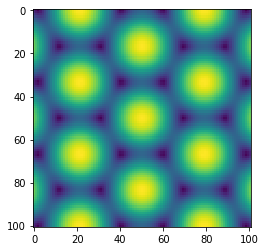

(2.0070948083372007, 3.0)

In [7]:
x, y = np.meshgrid(
    np.linspace(-2*np.pi, 2*np.pi, 101),
    np.linspace(-2*np.pi, 2*np.pi, 101),
)

c = np.abs(  # mirrors K_hex from generate_grid_cell_basis
    np.exp(1j*y) +
    np.exp(1j*(np.sqrt(3)/2*x - 0.5*y)) +
    np.exp(1j*(-np.sqrt(3)/2*x - 0.5*y))
) / 3 + 2

# c = 1 * (np.cos(x) * np.cos(y) + 1) / 2 + 2

plt.imshow(c)
plt.show()

np.min(c), np.max(c)

### 0. Some heatmap plots for the paper

In [8]:
# https://stackoverflow.com/a/45098466/1030876
from matplotlib.colors import ListedColormap
palette = sns.color_palette("RdBu_r", 512)
cmap = ListedColormap(palette)

/home/arvoelke/git/spa/nengo_spa/semantic_pointer.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)
/home/arvoelke/git/spa/nengo_spa/vocabulary.py:182: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=7, M=4, similarity=0.14)
  % (self.max_similarity, self.dimensions, len(self._key2idx), best_sim)
/home/arvoelke/git/spa/nengo_spa/vocabulary.py:182: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=7, M=5, similarity=0.26)
  % (self.max_similarity, self.dimensions, len(self._key2idx), best_sim)
/home/arvoelke/git/spa/nengo_spa/vocabulary.py:182: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=7, M=6, similarity=0.29)
  % (self.max_similarity, self.dimensions, len(self._key2idx), best_sim)
/home/arvoelke/git/spa/nengo_spa/vocabulary.py:182: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=7, M=7, similarity=

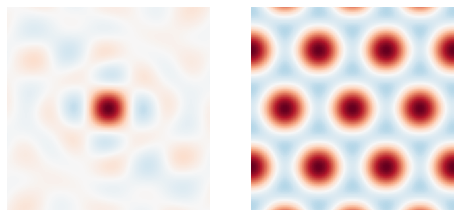

In [9]:
grid_scale = 2*np.pi / np.sqrt(6)  # email from Nicole
X, Y, d = generate_grid_cell_basis(1, 1, grid_scale, grid_scale)

scale = 6 * np.sqrt(2)
rng = np.random.RandomState(seed=0)

ssp_map = Spatial2D(dim=d, scale=scale, rng=rng, X=X, Y=Y)
ssp_map.build_grid(x_len=0.5, y_len=0.5, x_spaces=301, y_spaces=301, centered=True)
grid_sims = ssp_map.compute_heatmap(ssp_map.voc["Identity"])

ssp_map = Spatial2D(dim=512, scale=scale, rng=rng)
ssp_map.build_grid(x_len=0.5, y_len=0.5, x_spaces=301, y_spaces=301, centered=True)
normal_sims = ssp_map.compute_heatmap(ssp_map.voc["Identity"])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(normal_sims, vmin=-1, vmax=1, cmap=cmap)
axes[0].axis('off')
axes[0].axis('tight')
axes[0].axis('equal')
axes[0].axis('image')
axes[1].imshow(grid_sims, vmin=-1, vmax=1, cmap=cmap)
axes[1].axis('off')
axes[1].axis('tight')
axes[1].axis('equal')
axes[1].axis('image')

fig.savefig("../figures/heatmaps.pdf", bbox_inches='tight')

fig.show()

### 1. Look at how the DoFs scale with map size and X, Y method

In [84]:
dims = np.geomspace(256, 2048, 5, dtype=int)
scales = np.geomspace(np.sqrt(2), 50, 10)

rng = np.random.RandomState(seed=0)
colors = sns.cubehelix_palette(len(dims))

rcond = 1  # cutoff for singular values (inversely proportional to required SNR)
samples = 8192  # some sufficiently large number >> d
xy = ball.sample(samples, 2, rng=rng)

In [8]:
data = []
for d in dims:
    for method in ('Place Cell', 'Default', 'Recursive', 'Hex Recursive'):
        if method == 'Place Cell':
            # hack: this goes first and overwrites the local d, so that
            # the next iteration (the default method) will use the same d
            X, Y, d = generate(d)
            ssp_map = Spatial2D(dim=d, scale=1, rng=rng, X=X, Y=Y)
        elif method == 'Default':
            ssp_map = Spatial2D(dim=d, scale=1, rng=rng)
        elif method == 'Recursive':
            ssp_map = IterSpatial2D(dim=d, scale=1, rng=rng)
        elif method == 'Hex Recursive':
            ssp_map = RecursiveHexSpatial2D(dim=d, scale=1, rng=rng)
        else:
            assert False

        dofs = []

        for scale in scales:
            vecs = np.asarray([ssp_map.encode_point(x, y).v for x, y in xy*scale])
            eigvals = get_eigvals(vecs)
            try:
                dof = np.where(eigvals < rcond)[0][0]
            except IndexError:
                dof = d

            data.append({
                'Dimensions': d,
                'Radius': scale,
                'Degrees of Freedom': dof,
                'Method': method,
            })

/home/arvoelke/git/spa/nengo_spa/semantic_pointer.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


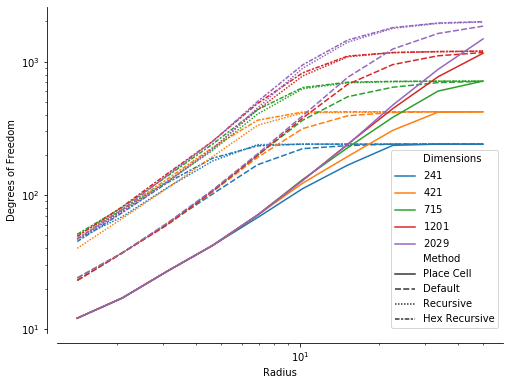

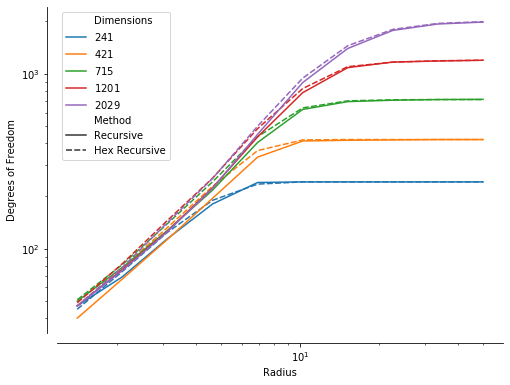

In [29]:
from pandas import DataFrame

df = DataFrame(data)
df["Dimensions"] = ["$%d$" % d for d in df["Dimensions"]]

plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Radius", y="Degrees of Freedom",
             hue="Dimensions", style="Method")
plt.xscale('log')
plt.yscale('log')
sns.despine(offset=10)
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["Method"] == "Recursive") |
                     (df["Method"] == "Hex Recursive")],
             x="Radius", y="Degrees of Freedom",
             hue="Dimensions", style="Method")
plt.xscale('log')
plt.yscale('log')
sns.despine(offset=10)
plt.show()

In [10]:
df[df["Radius"] == np.sqrt(2)]["Degrees of Freedom"]

0      12
10     23
20     47
30     45
40     12
50     23
60     40
70     47
80     12
90     24
100    50
110    51
120    12
130    23
140    47
150    49
160    12
170    24
180    47
190    47
Name: Degrees of Freedom, dtype: int64

### 2. Look at the basis vectors in SSP space

In [114]:
d = 1024
# X, Y, d = generate(d)
X = Y = None
print(d)

rng = np.random.RandomState(seed=0)
ssp_map = Spatial2D(dim=d, scale=1, rng=rng, X=X, Y=Y)
ssp_map.build_grid(x_len=np.sqrt(2), y_len=np.sqrt(2), x_spaces=101, y_spaces=101, centered=True)

1024


In [115]:
xy = ball.sample(d * 5, 2, rng=rng)
scale = np.sqrt(2)
vecs = np.asarray([ssp_map.encode_point(x, y).v for x, y in xy*scale])

u, s, v = np.linalg.svd(vecs.T.dot(vecs))
# u, s, v = np.linalg.svd(vecs.T)
basis = u  # columns of left-singular values
# basis = v  # columns of right-singular values
u.shape, s.shape, v.shape, np.count_nonzero(np.abs(s) > rcond)

((1024, 1024), (1024,), (1024, 1024), 21)

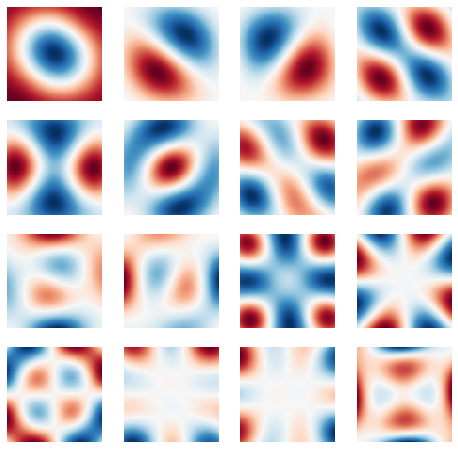

In [116]:
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

for i in range(rows):
    for j in range(cols):
        k = i*cols + j
        
        heatmap = ssp_map.compute_heatmap(spa.SemanticPointer(basis[:, k]))
        axes[i, j].imshow(heatmap, cmap=cmap)
        axes[i, j].axis('off')
        axes[i, j].axis('tight')
        axes[i, j].axis('equal')
        axes[i, j].axis('image')

fig.savefig("../figures/SSP-singular-values.pdf", bbox_inches='tight')

fig.show()

In [117]:
from nengo.utils.numpy import rms

# sanity check that these are indeed the basis functions that represent other X^x Y^y
n_basis = rows * cols
assert len(basis) == d

solver = nengo.solvers.Lstsq(rcond=rcond)
W, info = solver(basis[:, :n_basis], vecs.T)

# each column of W are weights over the basis vectors that reconstruct a given point in the region
assert W.shape == (n_basis, len(xy))
W.shape, np.mean(info['rmses'] / rms(vecs, axis=1))

((16, 5120), 0.06907081280581732)

### 2+. What about doing the same for the rSSP?

In [118]:
# d = 512
# ssp_map = IterSpatial2D(dim=d, scale=1, rng=rng)
ssp_map = RecursiveHexSpatial2D(dim=d, scale=1, rng=rng)
ssp_map.build_grid(x_len=np.sqrt(2), y_len=np.sqrt(2), x_spaces=101, y_spaces=101, centered=True)

In [119]:
xy = ball.sample(d * 5, 2, rng=rng)
# xy = rng.uniform(-1, 1, size=(d * 20, 2))
scale = np.sqrt(2)
vecs = np.asarray([ssp_map.encode_point(x, y).v for x, y in xy*scale])

u, s, v = np.linalg.svd(vecs.T.dot(vecs))
# u, s, v = np.linalg.svd(vecs.T)
basis = u  # columns of left-singular values
# basis = v  # columns of right-singular values
u.shape, s.shape, v.shape, np.count_nonzero(np.abs(s) > rcond)

((1024, 1024), (1024,), (1024, 1024), 36)

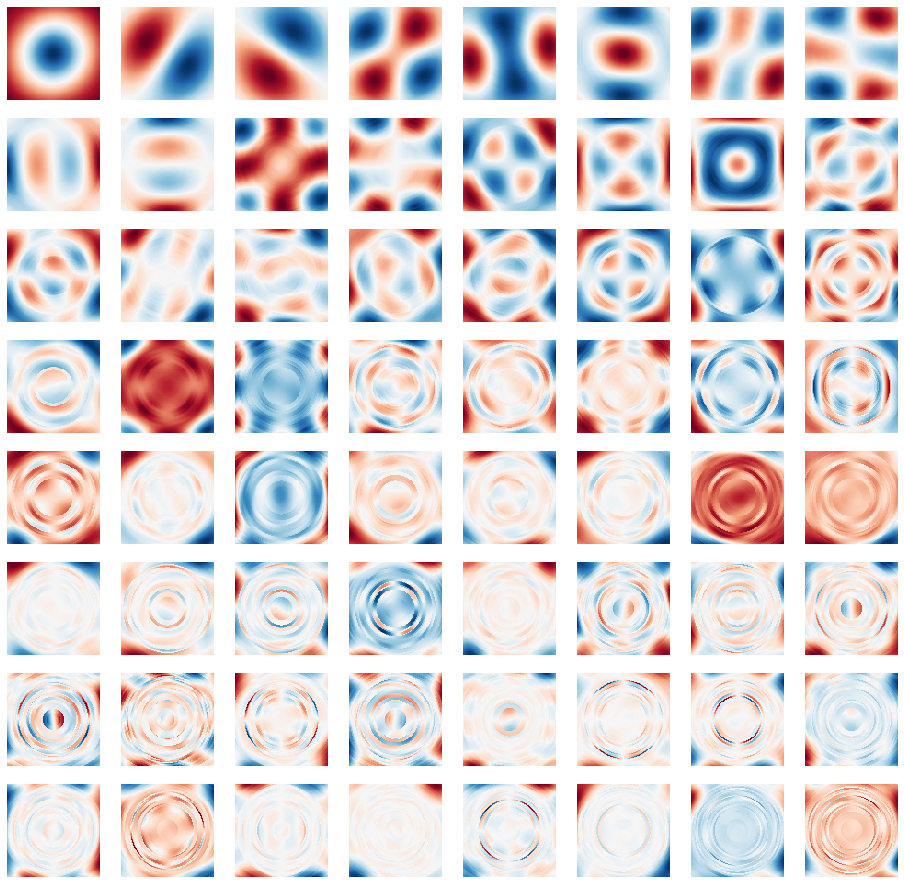

In [120]:
rows, cols = 8, 8

fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

for i in range(rows):
    for j in range(cols):
        k = i*cols + j
        
        heatmap = ssp_map.compute_heatmap(spa.SemanticPointer(basis[:, k]))
        axes[i, j].imshow(heatmap, cmap=cmap)
        axes[i, j].axis('off')
        axes[i, j].axis('tight')
        axes[i, j].axis('equal')
        axes[i, j].axis('image')

fig.savefig("../figures/rSSP-singular-values.pdf", bbox_inches='tight')

fig.show()

In [121]:
# sanity check that these are indeed the basis functions that represent other X^x Y^y
n_basis = rows * cols
assert len(basis) == d

solver = nengo.solvers.Lstsq(rcond=rcond)
W, info = solver(basis[:, :n_basis], vecs.T)

# each column of W are weights over the basis vectors that reconstruct a given point in the region
assert W.shape == (n_basis, len(xy))
W.shape, np.mean(info['rmses'] / rms(vecs, axis=1))

((64, 5120), 0.02158116308200383)

### 3. What about m-dimensional space?

In [20]:
from ssp.pointers import BaseVectors

d = 1024
samples = 16384
scale = np.sqrt(2)

n_dims = np.arange(1, 10)
cutoffs = []

for m in n_dims:
    pointer_gen = BaseVectors(d, rng=rng)
    axes = [spa.SemanticPointer(next(pointer_gen)) for _ in range(m)]
    pts = ball.sample(samples, m, rng=rng)

    vecs = np.asarray(
        [np.prod([B ** exp for B, exp in zip(axes, pt)]).v
         for pt in pts*scale]
    )
    eigvals = get_eigvals(vecs)
    cutoff = np.where(eigvals < rcond)[0][0]
    cutoffs.append(cutoff)

    print("%d Axes => %d DoF" % (m, cutoff))

1 Axes => 6 DoF
2 Axes => 24 DoF
3 Axes => 74 DoF
4 Axes => 174 DoF
5 Axes => 350 DoF
6 Axes => 558 DoF
7 Axes => 734 DoF
8 Axes => 902 DoF
9 Axes => 1002 DoF


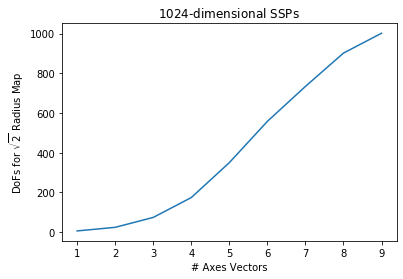

In [21]:
plt.figure()
plt.plot(n_dims, cutoffs)
plt.title("$%d$-dimensional SSPs" % d)
plt.xlabel("# Axes Vectors")
plt.ylabel(r"DoFs for $\sqrt{2}$ Radius Map")
plt.show()

### 4. More details for one particular dimensionality

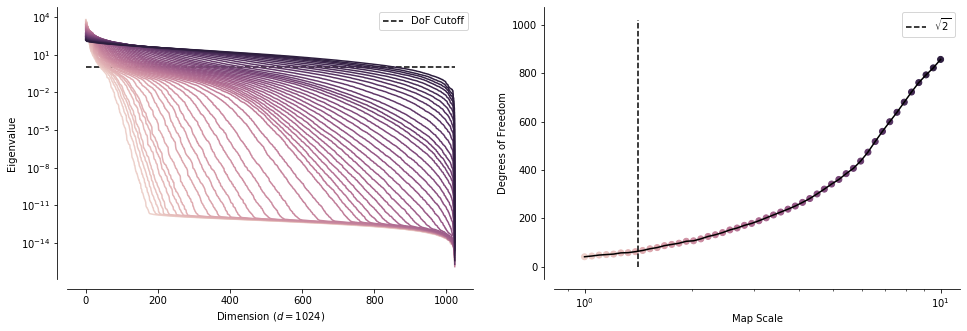

In [22]:
scales = np.geomspace(1, 10, 50)
colors = sns.cubehelix_palette(len(scales))  # sns.color_palette("cubehelix", len(scales))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

cutoffs = []
for scale, color in zip(scales, colors):
    vecs = np.asarray([ssp_map.encode_point(x, y).v for x, y in xy*scale])
    eigvals = get_eigvals(vecs)
    cutoff = np.where(eigvals < rcond)[0][0]

    axes[0].plot(eigvals, c=color)
    cutoffs.append(cutoff)

axes[0].hlines([rcond], 0, d-1, linestyle='--', label="DoF Cutoff")
axes[0].set_xlabel("Dimension ($d = %d$)" %d)
axes[0].set_ylabel("Eigenvalue")
axes[0].set_yscale('log')
axes[0].legend()

dofs = np.asarray(cutoffs)
axes[1].plot(scales, dofs, c='black')
axes[1].scatter(scales, dofs, c=colors)

axes[1].set_xscale('log')
axes[1].set_xlabel("Map Scale")
axes[1].vlines([np.sqrt(2)], 0, d-1, linestyle='--', label=r"$\sqrt{2}$")
axes[1].set_ylabel("Degrees of Freedom")
axes[1].legend()

sns.despine(offset=10)
plt.show()